In [1]:
import torch

In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [87]:
import numpy as np
import rustworkx as rx
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
# from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix, diags

## Tmp

In [4]:
graph = rx.PyDiGraph()

In [5]:
graph.add_nodes_from(list(range(5)))
graph.add_nodes_from(list(range(2)))

In [8]:
nodes = graph.node_indexes()

In [10]:
for i in nodes:
    print(i)

0
1
2
3
4
5
6


In [ ]:
len(graph)

7

In [ ]:
class GraphNode:
    def __init__(self, feature_descriptor):
        self.index = None
        self.feature_descriptor = feature_descriptor

    def __str__(self):
        return f"Index: {self.index} with Feature Descriptor: {self.feature_descriptor}"

In [42]:
def tmp_tree(branch_factor, total_nodes):
    """
    Creates a tree with the given branch factor and total nodes using rustworkx.

    Args:
        branch_factor: Number of children per node.
        total_nodes: Total number of nodes in the tree.

    Returns:
        tree: A rustworkx PyDiGraph representing the tree.
    """
    tree = rx.PyDiGraph()
    nodes = [tree.add_node(0)]  # Add the root node, initialize the list with it
    node_value = 1

    for node in nodes:
        if len(tree) >= total_nodes:
            break

        # Add children to the current node
        for _ in range(branch_factor):
            if len(tree) >= total_nodes:
                break

            child = tree.add_node(node_value if node_value != 6 else 'a')
            tree.add_edge(node, child, None)  # Add an edge from the current node to the child
            nodes.append(child)
            node_value += 1

    return tree

def print_tree(tree, root=0, indent=0):
    """
    Prints the tree in a hierarchical format.

    Args:
        tree: The rustworkx PyDiGraph tree.
        root: The current node to start printing from.
        indent: The current indentation level (used for formatting).
    """
    print(" " * indent + f"Node {tree[root]}")
    children = tree.adj_direction(root, direction=False).keys() #tree.adj[root]  # Get all children of the current node
    # print(children)
    for child in children:
        print_tree(tree, child, indent + 4)

# Example Usage
branch_factor = 3
total_nodes = 12
tree = tmp_tree(branch_factor, total_nodes)

In [43]:
print("Tree Structure:")
print_tree(tree)

Tree Structure:
Node 0
    Node 3
        Node 11
        Node 10
    Node 2
        Node 9
        Node 8
        Node 7
    Node 1
        Node a
        Node 5
        Node 4


In [48]:
type(tree.adj_direction(2, direction=False).keys())

dict_keys

In [47]:
tree.get_node_data(6)

'a'

In [39]:
tree.out_degree(0)

3

In [46]:
tree[6]

'a'

In [51]:
list(tree.successor_indices(1))

[6, 5, 4]

# Vocab Tree

In [96]:
class VocabularyTree:
    def __init__(self, num_branches: int, depth: int, image_descriptor_function, clustering_algorithm=None, **kwargs):
        """
        Initializes the Vocabulary Tree.

        Args:
            num_branches: Number of branches at each node.
            depth: Depth of the tree.
            image_descriptor: Function to extract features from images.
        """
        self.num_branches = num_branches
        self.depth = depth
        self.image_descriptor = image_descriptor_function
        self.tree = rx.PyDiGraph()  # Directed graph for the vocabulary tree
        # self.root = self.tree.add_node("root")  # Create root node

        if clustering_algorithm is None:
            self.clustering_algorithm = KMeans
        else:
            self.clustering_algorithm = clustering_algorithm
        # self.clustering_algorithm = clustering_algorithm or (lambda num_branches: KMeans()) #n_clusters=num_branches, random_state=42
        self.clustering_params = kwargs
        # self.image_table = None  # Will be built in create_image_table

        self.image_idx_image_mapping = {}
        self.weights = None
        self.bof = None

    def extract_image_features(self, imagepaths):
        """
        Extracts features for a given array of images.

        Args:
            images: Array of images.
            imagepaths: Array of image paths
        Returns:
            Array of feature descriptors for the images.
        """

        # return [self.image_descriptor(image) for image in images]
        image_descriptors = []
        for imagepath in imagepaths:
            image = cv2.imread(imagepath)
            image_descriptors.append(self.image_descriptor(image))
        return image_descriptors
        # return self.image_descriptor(images)
    

    def create_tree(self, feature_descriptions, current_node=0, node_value=None, current_depth=0):
        """
        Recursively builds the vocabulary tree.

        Args:
            feature_descriptions: Array of feature descriptions.
            current_node: Current node in the tree.
            node_value: Value of the current node (e.g., cluster centroid).
            current_depth: Current depth in the tree.
        """
        # Assign the node value
        # index = self.tree.add_node(GraphNode(node_value))
        # self.tree[index].index = index

        if current_node == 0: # If the current node is the root, add root to tree.
            self.tree.add_node(None)
            node_value = np.mean(feature_descriptions, axis=0)

        # self.tree[current_node] = node_value
        self.tree[current_node] = {'node_value': node_value, 'inverted_index': {}}


        # Stop if the max depth is reached or no more features to process
        if current_depth >= self.depth or len(feature_descriptions) < self.num_branches:
            return

        unique_descriptors = np.unique(feature_descriptions, axis=0) # Avoid creating clusters with no elements
        if len(unique_descriptors) < self.num_branches:
            return
        
        # Cluster the features into `num_branches` groups
        # kmeans = KMeans(n_clusters=self.num_branches, random_state=42, **self.clustering_params)
        clustering = self.clustering_algorithm(n_clusters=self.num_branches, random_state=42, **self.clustering_params)
        clustering.fit(feature_descriptions)

        # Create child nodes and recursively call fit
        for branch_id in range(self.num_branches):
            child_node = self.tree.add_node(None)  # Add a child node
            self.tree.add_edge(current_node, child_node, branch_id)  # Link child to current node

            # Get features belonging to the current cluster
            cluster_features = feature_descriptions[clustering.labels_ == branch_id]
            cluster_centroid = clustering.cluster_centers_[branch_id]

            # Recursive call
            self.create_tree(cluster_features, child_node, cluster_centroid, current_depth + 1)


    def build_inverted_index(self, feature_dict):
        """
        Traverses the tree with a feature and adds the image ID to the inverted index of the leaf node.

        Args:
            feature: A single descriptor vector.
            image_id: ID of the image to add to the inverted index.
        """

        for image_id, feature_descriptor in feature_dict.items(): # For each image
            for feature in feature_descriptor: # For each descriptor in that image
                current_node = 0

                # while self.tree[current_node]["type"] != "leaf":
                while self.tree.out_degree(current_node) > 0:
                    children = list(self.tree.successor_indices(current_node))
                    distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                    closest_child = children[np.argmin(distances)]

                    # Move to the closest child
                    current_node = closest_child

                # Add image ID to the leaf node's inverted index
                if image_id in self.tree[current_node]["inverted_index"]:
                    self.tree[current_node]["inverted_index"][image_id] += 1
                else:
                    self.tree[current_node]["inverted_index"][image_id] = 1

    def get_inverted_index(self, node):
        if self.tree.out_degree(node) == 0: # If node is a leaf
            # print(node)
            # print(self.tree[node])
            # if self.tree[node]["inverted_index"] == {}:
            #     print("Empty dict")
            # if self.tree[node]["inverted_index"] is None:
            #     print("Is None")
            return self.tree[node]["inverted_index"]
        else:
            inverted_idx = {}
            children = list(self.tree.successor_indices(node))
            for child in children:
                child_inverted_idx = self.get_inverted_index(child)
                for image_id, count in child_inverted_idx.items():
                    if image_id in inverted_idx:
                        inverted_idx[image_id] += count
                    else:
                        inverted_idx[image_id] = count
            return inverted_idx


    def compute_bof(self, num_images):
        num_nodes = len(self.tree)
        self.weights = np.zeros(num_nodes)

        # ------------ Without Sparse Matrices ------------
        # self.bof = np.zeros((num_images, num_nodes))
        
        # for node in self.tree.node_indexes():
        #     inverted_idx = self.get_inverted_index(node)
        #     self.weights[node] = np.log(num_images / len(inverted_idx))

        #     for image_id, count in inverted_idx.items():
        #         self.bof[image_id, node] = self.weights[node] * count
        

        # for image_id in range(num_images):
        #     self.bof[image_id] /= np.sum(self.bof[image_id]) # L1 Normalization


        # ------------ With Sparse Matrices ------------
        self.bof = lil_matrix((num_images, num_nodes))
        
        for node in self.tree.node_indexes():
            inverted_idx = self.get_inverted_index(node)
            self.weights[node] = np.log(num_images / len(inverted_idx))

            for image_id, count in inverted_idx.items():
                self.bof[(image_id, node)] = self.weights[node] * count
        

        self.bof = csr_matrix(self.bof)

        row_sums = self.bof.sum(axis=1)
        row_sums_reciprocal = 1.0 / row_sums
        diagonal_matrix = diags(row_sums_reciprocal.A1)
        normalized_matrix = diagonal_matrix.dot(self.bof)
        self.bof = normalized_matrix

    def fit(self, images):

        image_features = self.extract_image_features(images)

        cnt = 0
        non_null_features = []
        image_features_flattened = []
        idx_mapping = {}

        for i in range(len(image_features)):
            if image_features[i] is not None: # Drop images for which no features were extracted
                non_null_features.append(image_features[i])
                idx_mapping[cnt] = images[i]
                cnt += 1
                image_features_flattened.extend(image_features[i])
        image_features = np.array(image_features_flattened)

        image_ids = np.arange(len(non_null_features))
        self.image_idx_image_mapping = idx_mapping

        feature_dict = {image_id: features for image_id, features in zip(image_ids, non_null_features)}

        # image_ids = np.arange(len(images))

        # self.image_idx_image_mapping = {image_id: image for image_id, image in zip(image_ids, images)}

        # feature_dict = {image_id: features for image_id, features in zip(image_ids, image_features)}
        # image_features_flattened = []
        # for i in range(len(image_features)):
        #     print(i, end=" ")
        #     if i % 100 == 0:
        #         print("\n")
        #     if image_features[i] is None:
        #         print("Is none\n")
        #     image_features_flattened.extend(image_features[i])
        # image_features = np.array(image_features_flattened)

        # unique_descriptors = np.unique(image_features, axis=0) # Take unique descriptors to avoid creating clusters with no elements
        # self.create_tree(unique_descriptors)

        self.create_tree(image_features)
        self.build_inverted_index(feature_dict)
        self.compute_bof(len(non_null_features))


    def get_query_bof(self, feature_descriptors):
        bof = np.zeros(len(self.tree))

        for feature in feature_descriptors:
            current_node = 0
            
            bof[current_node] += 1*self.weights[current_node]

            while self.tree.out_degree(current_node) > 0:
                children = list(self.tree.successor_indices(current_node))
                distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                closest_child = children[np.argmin(distances)]

                # Move to the closest child
                current_node = closest_child

                bof[current_node] += 1*self.weights[current_node]

            # bof[current_node] += 1
        
        return bof

    def query(self, image):
        image_features = self.image_descriptor(image)

        qbof = self.get_query_bof(image_features)
        qbof /= np.sum(qbof)

        non_zero_q_nodes = np.nonzero(qbof)[0]

        scores = {}


        # ------------ Without Sparse Matrices ------------
        # for image_id in range(len(self.bof)):
            # bof = self.bof[image_id]
        
        # ------------ With Sparse Matrices ------------
        for image_id in range(graph.shape[0]):
            bof = self.bof.getrow(image_id).toarray()[0]
            
            score = 2
            
            non_zero_bof_nodes = np.nonzero(bof)[0]
            intersection = np.intersect1d(non_zero_q_nodes, non_zero_bof_nodes)

            for i in intersection:
                score += np.abs(qbof[i] - bof[i]) - np.abs(qbof[i]) - np.abs(bof[i])

            # score = np.sum(bof[intersection])
            scores[image_id] = score

        # Sort Scores
        scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
        images = {k: self.image_idx_image_mapping[k] for k in scores.keys()}
        return scores, images


# Descriptors

In [55]:
def opponent_sift(image):
    # Convert image to opponent color space
    R, G, B = image[:, :, 2], image[:, :, 1], image[:, :, 0]
    O1 = (R - G) / np.sqrt(2)
    O2 = (R + G - 2 * B) / np.sqrt(6)
    O3 = (R + G + B) / np.sqrt(3)
    opponent_image = np.stack([O1, O2, O3], axis=-1)

    # Apply SIFT on each channel
    sift = cv2.SIFT_create()
    descriptors = []
    for i in range(3):
        _, desc = sift.detectAndCompute(opponent_image[:, :, i].astype(np.uint8), None)
        if desc is not None:
            descriptors.append(desc)

    return np.vstack(descriptors) if descriptors else None

def dense_sift_hsv(image, step_size=8):
    # Convert image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sift = cv2.SIFT_create()

    # Dense keypoints for each channel
    descriptors = []
    for i in range(3):
        channel = hsv_image[:, :, i]
        keypoints = [cv2.KeyPoint(x, y, step_size) for y in range(0, channel.shape[0], step_size)
                                                 for x in range(0, channel.shape[1], step_size)]
        _, desc = sift.compute(channel, keypoints)
        if desc is not None:
            descriptors.append(desc)

    return np.vstack(descriptors) if descriptors else None

def color_histogram_sift(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply SIFT on each channel
    sift = cv2.SIFT_create()
    descriptors = []
    for i in range(3):  # Iterate over H, S, and V channels
        _, desc = sift.detectAndCompute(hsv_image[:, :, i], None)
        if desc is not None:
            descriptors.append(desc)

    return np.vstack(descriptors) if descriptors else None

def extract_rgb_hsv_lab_features(image, hsv_bins=(8, 8, 8), lab_bins=16):
    """
    Extract combined features from the HSV and LAB color spaces from an RGB image.
    
    Parameters:
        image (numpy.ndarray): Input image (RGB format).
        hsv_bins (tuple): Number of bins for H, S, and V channels in HSV histogram.
        lab_bins (int): Number of bins for L channel histogram in LAB space.
    
    Returns:
        numpy.ndarray: Combined and normalized feature vector.
    """
    
    # Convert BGR to HSV and LAB
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # HSV histogram
    hsv_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, hsv_bins, [0, 180, 0, 256, 0, 256])
    hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
    
    # LAB L-channel texture histogram
    l_channel = lab_image[:, :, 0]
    lab_hist = cv2.calcHist([l_channel], [0], None, [lab_bins], [0, 256])
    lab_hist = cv2.normalize(lab_hist, lab_hist).flatten()
    
    # Combine HSV and LAB features
    combined_features = np.hstack((hsv_hist, lab_hist))
    return normalize(combined_features.reshape(1, -1)).flatten()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

resnet_feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-2])
resnet_feature_extractor = resnet_feature_extractor.to(device)


def extract_resnet_features(image):
    """
    Extract feature vector from an image using ResNet-50.
    
    Parameters:
        image_path (str): Path to the input image.
    
    Returns:
        torch.Tensor: Extracted feature vector of size [2048].
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # model = models.resnet50(pretrained=True)
    # model = torch.nn.Sequential(*list(model.children())[:-1])
    # model = model.to(device)
    # model.eval()

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # img = Image.open(image_path).convert("RGB")
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # with torch.no_grad():
    #     features = resnet_model(img_tensor).squeeze() 

    # return features.cpu()

    with torch.no_grad():
        feature_maps = resnet_feature_extractor(img_tensor)
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension
    _, H, W = feature_maps.shape

    # Identify keypoints using saliency or max responses (simplest approach: dense sampling)
    keypoints = []
    descriptors = []

    for i in range(H):
        for j in range(W):
            keypoints.append((i, j))  # Spatial location of keypoint
            descriptors.append(feature_maps[:, i, j].cpu().numpy())  # Feature vector

    return np.array(descriptors)



# class SuperPointModel(torch.nn.Module):
#     def __init__(self):
#         super(SuperPointModel, self).__init__()
#         self.model = torch.hub.load('magicleap/SuperPointPretrainedNetwork', 'superpoint')

#     def forward(self, image):
#         # Forward pass
#         return self.model(image.unsqueeze(0))

# superpoint = SuperPointModel().to(device)
# superpoint.eval()

# def extract_superpoint_features(image):
#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     tensor_image = F.to_tensor(gray).unsqueeze(0).to(device)

#     with torch.no_grad():
#         output = superpoint(tensor_image)

#     keypoints = output['keypoints'][0].cpu().numpy()
#     descriptors = output['descriptors'][0].cpu().numpy()
#     return keypoints, descriptors

c:\Users\malio\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\malio\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Read Dataset

In [54]:
def read_and_plot_img(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()


def plot_top_k_images(scores, images, k):
    """
    Plots the top k images with their scores as titles.

    Args:
        scores: A dictionary with image IDs as keys and scores as values.
        images: A dictionary with image IDs as keys and images (numpy arrays) as values.
        k: The number of top images to plot.
    """
    # Sort scores in descending order and select the top k
    top_k_ids = sorted(scores, key=scores.get, reverse=False)[:k]
    top_k_scores = [scores[image_id] for image_id in top_k_ids]
    top_k_images = [images[image_id] for image_id in top_k_ids]

    # Create subplots
    n_cols = min(3, k)  # Max 5 images per row
    n_rows = (k + n_cols - 1) // n_cols  # Calculate rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

    # Flatten axes for easy iteration
    axes = axes.ravel() if k > 1 else [axes]

    # Plot images
    for i in range(k):
        img = top_k_images[i]
        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {top_k_scores[i]:.2f}", fontsize=10)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(k, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
tmp_img_path = os.getcwd() + "\\dataset\\images\\1163.jpg"
tmp_img_bgr = cv2.imread(tmp_img_path)
tmp_img_rgb = cv2.cvtColor(tmp_img_bgr, cv2.COLOR_BGR2RGB)
# np.array([tmp_img_bgr[:, :, 2], tmp_img_bgr[:, :, 1], tmp_img_bgr[:, :, 0]])

In [ ]:
tmp_img_bgr.shape

(80, 60, 3)

In [ ]:
type(tmp_img_bgr), type(tmp_img_bgr[0]), type(tmp_img_bgr[0][0]), type(tmp_img_bgr[0][0][0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.uint8)

In [ ]:
# cv2.imshow('image', tmp_img_bgr)
# cv2.waitKey(0)
# # closing all open windows
# cv2.destroyAllWindows()

In [ ]:
new_styles = pd.read_csv('big_dataset\\archive\\fashion-dataset\\styles.csv', on_bad_lines='skip')

In [9]:
new_styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
df = pd.read_excel('styles_filtered.xlsx')

In [11]:
big_df = pd.merge(new_styles, df, on='id')

In [12]:
big_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
3,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
4,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt


In [14]:
big_df.reset_index(drop=True, inplace=True)

In [24]:
big_df['image_path'] = big_df['id'].apply(lambda x: os.getcwd() + "\\big_dataset\\dataset\\fashion-dataset\\images\\" + str(x) + ".jpg")

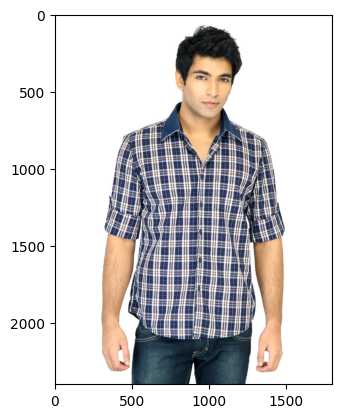

In [31]:
read_and_plot_img(big_df.iloc[0]['image_path'])

In [35]:
for i, path in enumerate(big_df['image_path']):
    tmp_path_img = cv2.imread(path)
    if tmp_path_img is None:
        print(f"{i}: {path}")

2025: e:\NEU\CV\project\big_dataset\dataset\fashion-dataset\images\39403.jpg
5131: e:\NEU\CV\project\big_dataset\dataset\fashion-dataset\images\39410.jpg
10182: e:\NEU\CV\project\big_dataset\dataset\fashion-dataset\images\39401.jpg
11514: e:\NEU\CV\project\big_dataset\dataset\fashion-dataset\images\39425.jpg


In [33]:
big_df[big_df['id'] == 6695]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
6209,6695,Women,Apparel,Topwear,Tshirts,White,Summer,2011.0,Casual,UCB Women's Crystal Benetton At Front White T-...,e:\NEU\CV\project\big_dataset\dataset\fashion-...


In [47]:
train_dir = os.getcwd() +'\\alexey_dataset\\clothing-dataset-small-master\\clothing-dataset-small-master\\train'

# Initialize lists to store image types and paths
image_types = []
image_paths = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(train_dir):
    for file in files:
        # Check if the file is an image (you can add more extensions if needed)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Get the image type (folder name)
            image_type = os.path.basename(root)
            
            # Get the full image path
            image_path = os.path.join(root, file)
            
            # Append to lists
            image_types.append(image_type)
            image_paths.append(image_path)

# Create a DataFrame
new_train_df = pd.DataFrame({
    'type': image_types,
    'image_path': image_paths
})


In [52]:
test_dir = os.getcwd() +'\\alexey_dataset\\clothing-dataset-small-master\\clothing-dataset-small-master\\test'

# Initialize lists to store image types and paths
image_types = []
image_paths = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(test_dir):
    for file in files:
        # Check if the file is an image (you can add more extensions if needed)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Get the image type (folder name)
            image_type = os.path.basename(root)
            
            # Get the full image path
            image_path = os.path.join(root, file)
            
            # Append to lists
            image_types.append(image_type)
            image_paths.append(image_path)

# Create a DataFrame
new_test_df = pd.DataFrame({
    'type': image_types,
    'image_path': image_paths
})


In [53]:
len(new_train_df), len(new_test_df)

(3068, 372)

In [48]:
new_train_df.head()

,type,image_path
0,dress,e:\NEU\CV\project\alexey_dataset\clothing-data...
1,dress,e:\NEU\CV\project\alexey_dataset\clothing-data...
2,dress,e:\NEU\CV\project\alexey_dataset\clothing-data...
3,dress,e:\NEU\CV\project\alexey_dataset\clothing-data...
4,dress,e:\NEU\CV\project\alexey_dataset\clothing-data...


In [49]:
new_train_df['type'].value_counts()

type
t-shirt       795
pants         468
longsleeve    455
shirt         290
dress         241
shorts        202
shoes         198
outwear       184
hat           123
skirt         112
Name: count, dtype: int64

In [ ]:
for i, path in enumerate(new_train_df['image_path']):
    tmp_path_img = cv2.imread(path)
    if tmp_path_img is None:
        print(f"{i}: {path}")

KeyError: 'path'

In [76]:
type_proportions = new_train_df['type'].value_counts(normalize=True)

# Calculate the number of samples to take from each label
n_samples = 1000
samples_per_type = (type_proportions * n_samples).round().astype(int)

# Initialize an empty dataframe to store the sampled rows
sampled_df = pd.DataFrame()

# Sample rows for each label
for label, n in samples_per_type.items():
    label_df = new_train_df[new_train_df['type'] == label]
    if len(label_df) > n:
        sampled_label_df = label_df.sample(n=n, random_state=42)
    else:
        sampled_label_df = label_df
    sampled_df = pd.concat([sampled_df, sampled_label_df])

In [79]:
sampled_df['type'].value_counts()

type
t-shirt       259
pants         153
longsleeve    148
shirt          95
dress          79
shorts         66
shoes          65
outwear        60
hat            40
skirt          37
Name: count, dtype: int64

In [81]:
sampled_df.reset_index(drop=False, inplace=True)

In [235]:
styles = pd.read_csv('dataset\\styles.csv', on_bad_lines='skip')

In [236]:
styles['image_path'] = styles['id'].apply(lambda x: os.getcwd() + "\\dataset\\images\\" + str(x) + ".jpg")

In [ ]:
for i, path in enumerate(styles['image_path']):
    tmp_path_img = cv2.imread(path)
    if tmp_path_img is None:
        print(f"{i}: {path}")

In [ ]:
styles.drop(styles.index[[3114, 6695, 16194, 18227, 32309, 36381, 40000]], inplace=True)

In [ ]:
# styles_tmp = pd.read_csv('dataset\\styles.csv', on_bad_lines='skip' , skiprows=60, nrows=75, names=[0,1,2])

In [238]:
styles.reset_index(drop=True, inplace=True)

In [214]:
len(styles)

44424

In [4]:
styles_1000 = pd.read_csv('dataset\\styles.csv', on_bad_lines='skip', nrows=1000)

In [46]:
styles_100 = pd.read_csv('dataset\\styles.csv', on_bad_lines='skip', nrows=100)

In [ ]:
styles_100['image_path'] = styles_100['id'].apply(lambda x: os.getcwd() + "\\dataset\\images\\" + str(x) + ".jpg")
styles_1000['image_path'] = styles_1000['id'].apply(lambda x: os.getcwd() + "\\dataset\\images\\" + str(x) + ".jpg")

In [169]:
styles_1000['masterCategory'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items'], dtype=object)

In [167]:
styles_1000['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin'], dtype=object)

In [172]:
styles_1000[styles_1000['subCategory']=='Innerwear'].iloc[:3]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
18,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016,Casual,Bwitch Beige Full-Coverage Bra BW335,e:\NEU\CV\project\dataset\images\51832.jpg
47,17871,Men,Apparel,Innerwear,Briefs,Maroon,Winter,2016,Casual,Levis Men Boxer Maroon Brief,e:\NEU\CV\project\dataset\images\17871.jpg
53,32138,Men,Apparel,Innerwear,Briefs,Blue,Summer,2016,Casual,Playboy Men Blue Titanium Briefs,e:\NEU\CV\project\dataset\images\32138.jpg


In [175]:
styles_1000[styles_1000['subCategory']=='Topwear']['articleType'].unique()

array(['Shirts', 'Tshirts', 'Tops', 'Sweatshirts', 'Kurtas', 'Waistcoat',
       'Rain Jacket', 'Blazers', 'Shrug', 'Dupatta', 'Tunics', 'Jackets',
       'Sweaters', 'Kurtis'], dtype=object)

In [176]:
styles_1000['articleType'].unique()

array(['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks',
       'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra',
       'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant',
       'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',
       'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',
       'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',
       'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',
       'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',
       'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',
       'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',
       'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',
       'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',
       'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag',
       'Tracksuits', 'S

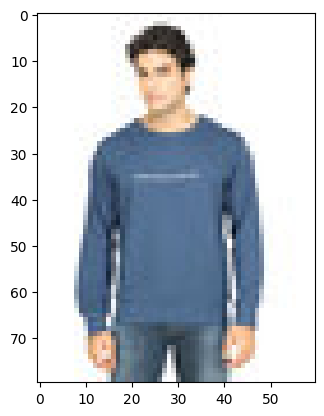

In [185]:
read_and_plot_img(styles_1000[styles_1000['articleType']=='Sweatshirts'].iloc[2]['image_path'])

In [ ]:
# styles_100['image_path'] = styles_100['id'].apply(lambda x: os.getcwd() + "\\dataset\\images\\" + str(x) + ".jpg")

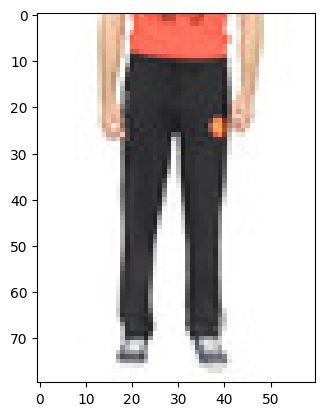

In [18]:
# cv2.imread(styles_1000.iloc[0]['image_path'])

read_and_plot_img(styles_1000.iloc[3]['image_path'])

# Experimentation

In [20]:
images = styles_1000['image_path'].apply(lambda x: cv2.imread(x))

In [49]:
images_100 = styles_100['image_path'].apply(lambda x: cv2.imread(x))

In [128]:
for k, i in enumerate(styles_100['image_path']):
    print(i)
    if k>5:
        break

e:\NEU\CV\project\dataset\images\15970.jpg
e:\NEU\CV\project\dataset\images\39386.jpg
e:\NEU\CV\project\dataset\images\59263.jpg
e:\NEU\CV\project\dataset\images\21379.jpg
e:\NEU\CV\project\dataset\images\53759.jpg
e:\NEU\CV\project\dataset\images\1855.jpg
e:\NEU\CV\project\dataset\images\30805.jpg


In [ ]:
len(images)

1000

In [210]:
tmp_img = cv2.imread(styles_100.iloc[0]['image_path'])

## Opponent SIFT

In [16]:
tree_ops = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=opponent_sift)

In [161]:
# ogs_images = tree_ops.extract_image_features((images_100))
ogs_images = tree_ops.extract_image_features(styles_1000['image_path'])

In [153]:
image_features_flattened = []
for i in range(len(ogs_images)):
    image_features_flattened.extend(ogs_images[i])
image_features = np.array(image_features_flattened)

In [ ]:
# unique_descriptors = np.unique(image_features, axis=0)

In [156]:
image_features.shape

(62638, 128)

In [209]:
opponent_sift(tmp_img).shape

(134, 128)

In [224]:
for i, path in enumerate(styles['image_path']):
    tmp_path_img = cv2.imread(path)
    if tmp_path_img is None:
        print(f"{i}: {path}")

In [ ]:
styles.iloc[3114]['image_path']

opponent_sift(tmp_img)

'e:\\NEU\\CV\\project\\dataset\\images\\35127.jpg'

In [244]:
# tree_ops.fit(images_100)
tree_ops.fit(styles['image_path'])

MemoryError: Unable to allocate 343. GiB for an array with shape (44411, 1037313) and data type float64

In [233]:
opponent_sift(cv2.imread(styles.iloc[3114]['image_path']))

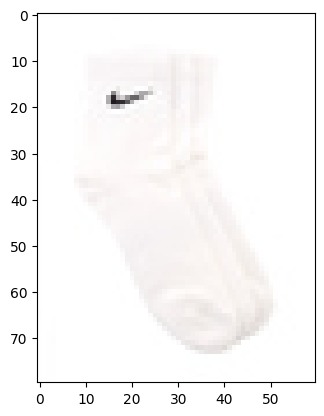

In [241]:
read_and_plot_img(styles.iloc[18227]['image_path'])

In [163]:
query_img = cv2.imread(styles_1000.iloc[120]['image_path'])

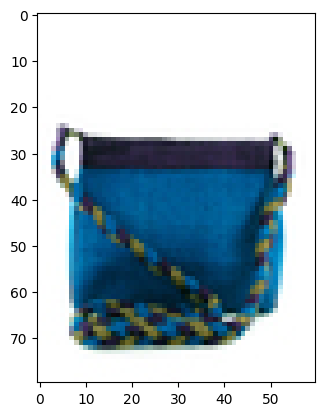

In [164]:
read_and_plot_img(styles_1000.iloc[120]['image_path'])

In [ ]:
scores, res = tree_ops.query(query_img)

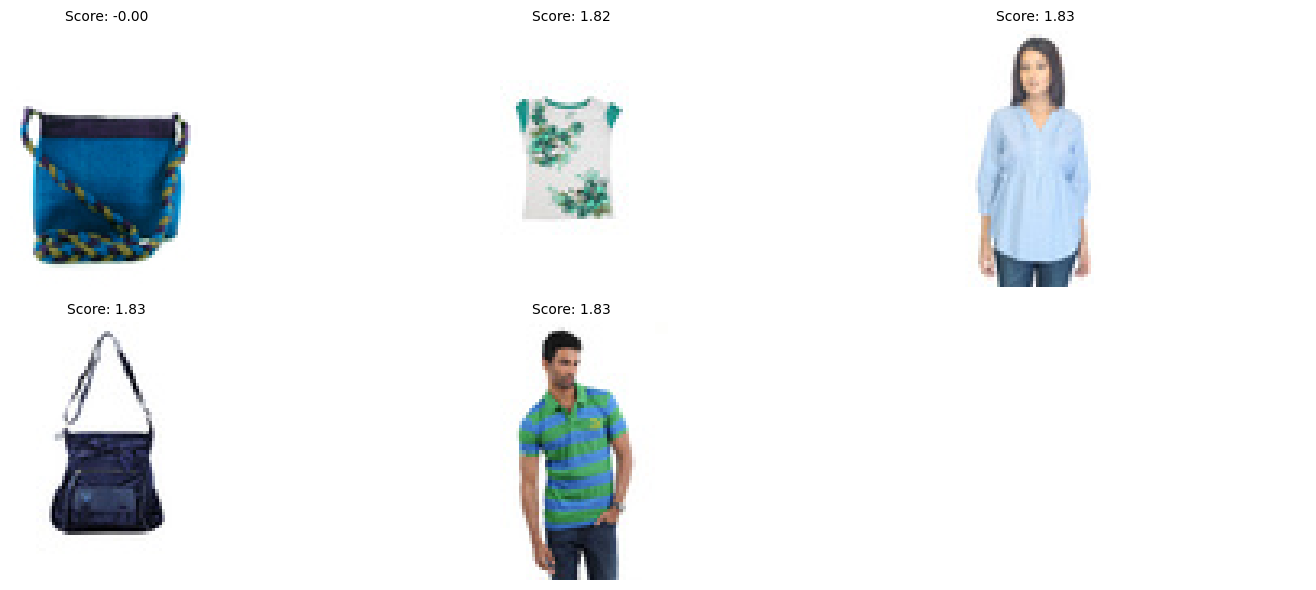

In [ ]:
plot_top_k_images(scores, res, 5)

In [56]:
tree_ops_train = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=opponent_sift)

In [57]:
tree_ops_train.fit(new_train_df['image_path'])

In [58]:
import pickle

In [59]:
with open('tree_ops_32_6_alexey_train_full.pkl', 'wb') as f:
    pickle.dump(tree_ops_train, f)

In [63]:
f.close()

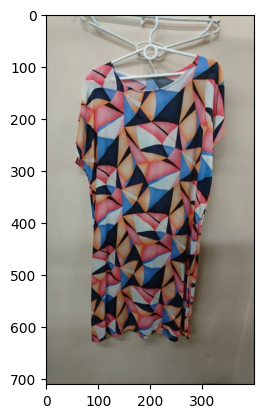

In [60]:
query_ind = 0
test_query_img = cv2.imread(new_test_df.iloc[query_ind]['image_path'])
read_and_plot_img(new_test_df.iloc[query_ind]['image_path'])

In [61]:
tree_ops_train_scores, tree_ops_train_res = tree_ops_train.query(test_query_img)

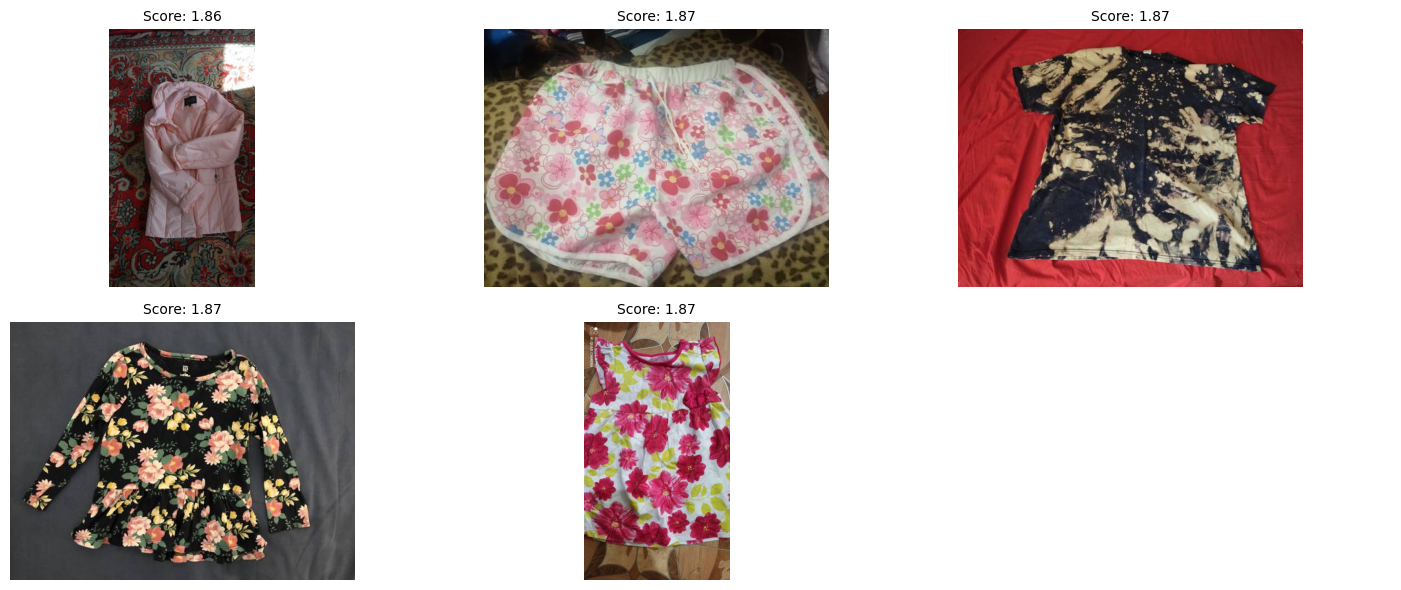

In [62]:
plot_top_k_images(tree_ops_train_scores, tree_ops_train_res, 5)

In [64]:
with open('tree_ops_32_6_alexey_train_full.pkl', 'rb') as f:
    tree_ops_train_pkl = pickle.load(f)

In [65]:
tree_ops_train_scores_pkl, tree_ops_train_res_pkl = tree_ops_train_pkl.query(test_query_img)

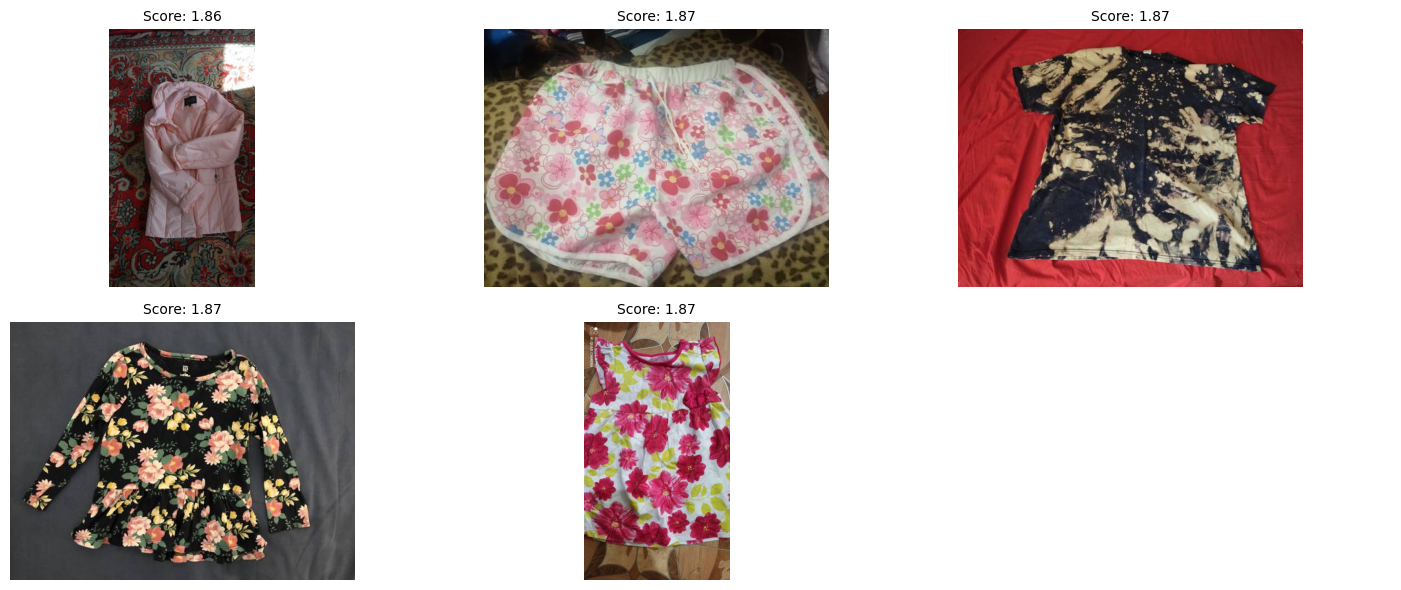

In [66]:
plot_top_k_images(tree_ops_train_scores_pkl, tree_ops_train_res_pkl, 5)

## Resnet

In [91]:
tmp_resnet_features = extract_resnet_features(test_query_img)

In [92]:
tmp_resnet_features.shape

(49, 2048)

In [97]:
tree_resnet_train = VocabularyTree(num_branches=16, depth=6, image_descriptor_function=extract_resnet_features)

In [ ]:
tree_resnet_train.fit(sampled_df['image_path'])

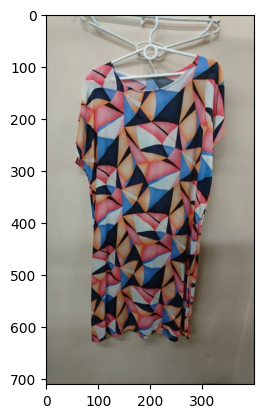

In [99]:
read_and_plot_img(new_test_df.iloc[query_ind]['image_path'])

In [103]:
tree_resnet_train_scores, tree_resnet_train_res = tree_resnet_train.query(test_query_img)

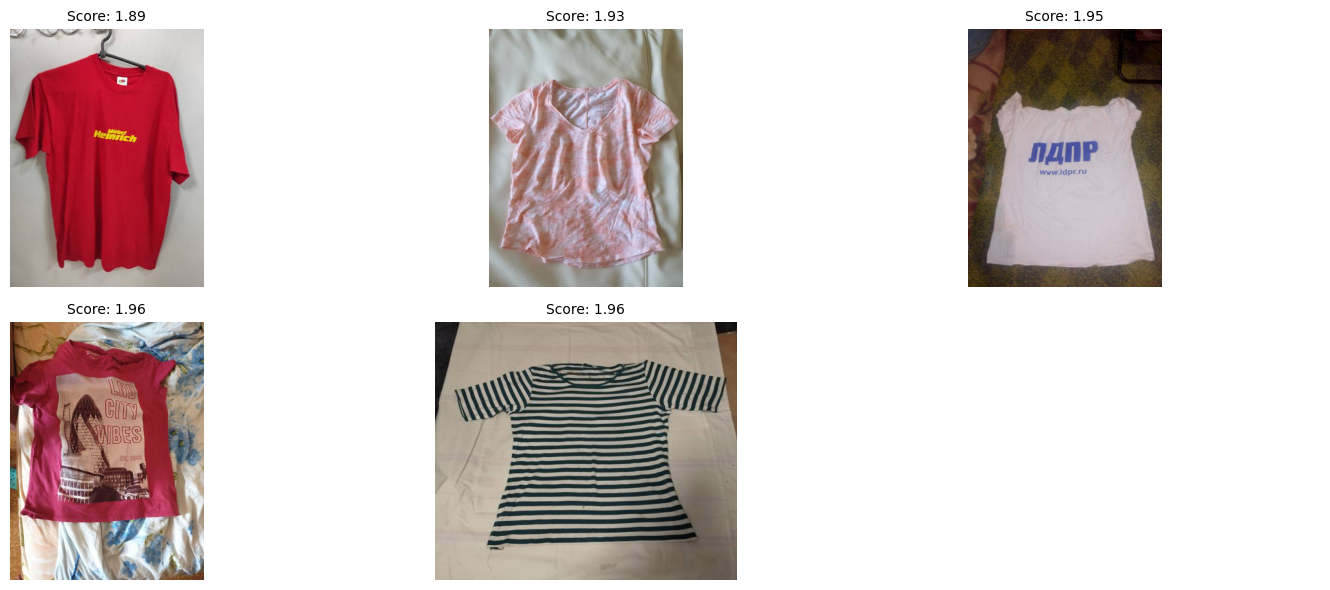

In [104]:
plot_top_k_images(tree_resnet_train_scores, tree_resnet_train_res, 5)